# P5: Generative Adversarial Networks (GAN)

En esta práctica entrenaremos un modelo basado en redes generativas adversarias para la generación de imágenes de dígitos manuscritos de forma automática. Como conjunto de datos de entrenamiento utilizaremos MNIST, conjunto de datos ya utilizado en la primera práctica de clasificación con un perceptrón multicapa.

El número generado tendrá una apariencia variable pero debe corresponderse con el número proporcionado como entrada, es decir, se trata de una generación condicionada.

## Entorno
La siguiente celda importa las bibliotecas y módulos esenciales de PyTorch y Torchvision necesarios para trabajar con redes neuronales, procesar datos y entrenar modelos.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Configuración

A continuación se proporcionan valores iniciales para los hiperparámetros del modelos. Estos valores se pueden modificar dependiendo de cada implementación pero deberían proporcionar un buen punto de partida.

In [3]:
# Hyperparameters
batch_size = 128
image_size = 28
nz = 100             # Dimensionality of latent noise vector
num_classes = 10     # For MNIST digits [0-9]
embedding_dim = 50   # Dimension for label embedding
ngf = 64             # Size of feature maps in generator
ndf = 64             # Size of feature maps in discriminator
num_epochs = 25
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Conjunto de datos
Se debe crear el dataset y dataloader de Pytorch para MNIST, utilizando el conjunto de entrenamiento disponible en `torchvision.datasets`.

In [5]:
# Transformación: Escalamos las imágenes a [-1, 1] para usar Tanh en la salida del generador
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normaliza a [-1, 1] (1 canal de MNIST)
])

# Dataset: MNIST de entrenamiento
dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2, #Num de nucleos para cargar los datos
    pin_memory=True  # aumenta la velocidad de comunicación entre gpu y cpu
)


## Generador
El generador se encarga de generar imágenes sintéticas. Recibirá como entrada para cada elemento del batch un vector de ruido calculado aleatoriamente para dar variabilidad a la imagen de salida y un valor numérico entre 0 y 9 que condiciona la imagen resultado. El generador tendrá la siguiente arquitectura:
- Embedding: convertir las etiquetas 0..9 a una representación en forma de vector.
- Concatenación del vector de ruido aleatorio con el embedding de la clase dada.
- Capa totalmente conectada que reduce la dimensión del vector concatenado a un vector de `hgf x 7 x 7` elementos.
- Deconvolución que aumenta la resolución de `7x7` a `14x14`.
- Deconvolución que aumenta la resolución de `14x14` a `28x28` con función de activación tangente hiperbólica.

Nota: las capas ocultas contarán con normalización tipo batch y ReLU como función de normalización.

Nota: las deconvoluciones tienen filtros `4x4`, `stride=2` y `padding=1`.

In [7]:
class Generator(nn.Module):
    def __init__(self, nz, num_classes, embedding_dim, ngf, out_channels=1):
        super().__init__()

        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.input_dim = nz + embedding_dim # Se concatenan el vector ruido y el vector embedding: esto sera el input de la red

        self.fc = nn.Linear(self.input_dim, ngf * 7 * 7) #ngf es el numero de mapas de características

        # deconv hace lo contrario a una convolución, es decir, aumenta el número de características
        self.deconv1 = nn.Sequential(
            #en una convolucional el ngf aumenta en cada capa, en una deconvolucional disminuye en cada capa
            nn.ConvTranspose2d(ngf, ngf // 2, kernel_size=4, stride=2, padding=1),
            #output_size = (input_size - 1) * stride - 2 * padding + kernel_size
            #output_size = 14 x 14
            #kernel_size: Es el tamaño del filtro que se usará en la operación (4x4)
            #stride: Es el paso con el que el filtro se mueve sobre la entrada, se mueve 2 píxeles a la vez
            #padding: agrega píxeles alrededor de la entrada para asegurarse de que el filtro se pueda aplicar de manera uniforme
            nn.BatchNorm2d(ngf // 2), #normaliza todos los valores de cada canal(32), en este caso serían 128 * 14 * 14 = 25088 valores para cada canal
            nn.ReLU(True)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(ngf // 2, out_channels, kernel_size=4, stride=2, padding=1), #out_channels es 0 porque las imagenes estan en escalas de gris
            #salida = (batch_size, 1, 28, 28) al igual que las imagenes
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, noise, labels):
        # labels: [batch_size], noise: [batch_size, nz] <-- TIENEN ESTAS  DIMENSIONES, se realiza en paralelo
        label_embedding = self.embedding(labels)  # → [batch_size, embedding_dim]
        x = torch.cat([noise, label_embedding], dim=1)  # → [batch_size, nz + embedding_dim]

        x = self.fc(x)  # → [batch_size, ngf * 7 * 7]
        x = x.view(-1, ngf, 7, 7)  # Reshape for conv: [batch_size, ngf, 7, 7]

        x = self.deconv1(x)  # → [batch_size, ngf//2, 14, 14]
        x = self.deconv2(x)  # → [batch_size, 1, 28, 28]

        return x



## Discriminador
 El discriminador es el adversario del generador y se encarga de intentar identificar las imágenes que se han generado de forma sintética de las imágenes reales del conjunto de datos original. Dado que en nuestro caso las imágenes generadas no solo se deben parecer a las originales sino que además deben representar la etiqueta 0..9 que se pasa como entrada, el discriminador también recibirá esta etiqueta y se encargará de clasificar entre real o sintético teniendo en cuenta que se parezca a la etiqueta.

La arquitectura del discriminador será la siguiente:

- Embedding: convertir las etiquetas 0..9 a una representación en forma de vector.
- Capa totalmente conectada que convierte el embedding a un vector de tamaño `in_channels * image_size * image_size`.
- El embedding pasado por la capa totalmente conectada se concatena con la imagen de entrada.
- El mapa de características concatenado se pasa por dos capas convolucionales con filtros de `4x4`, `stride=2` y `padding=1`.
- Capa totalmente conectada para la que debes decidir el número de neuronas de salida con `Sigmoid` como función de activación.

Nota: las capas ocultas contarán con normalización tipo batch y LeakyReLU como función de normalización.

In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, ndf, in_channels=1, image_size=28):
        super().__init__()
        # Embedding de la etiqueta
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        # FC para expandir el embedding a (in_channels * image_size * image_size)
        self.fc_label = nn.Linear(embedding_dim, in_channels * image_size * image_size)

        # Bloques convolucionales para procesar la imagen + etiqueta
        # Cada conv: kernel 4x4, stride=2, padding=1
        # Se usa BatchNorm + LeakyReLU
        self.conv_blocks = nn.Sequential(
            #no hacemos una deconvolucion, sino una convolución para que el discriminador pueda analizar al detalle, aumentando el numero de mapas de caracteristicas
            nn.Conv2d(in_channels * 2, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # Segunda conv: ndf -> ndf*2
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True) #se usa en vez de ReLu en gans para dejar pasar una pequeña cantidad de valores negativos, para que no mueran muchas neuronas si los gradientes van a 0
        )

        # Capa final: FC sobre el vector aplanado -> real/fake
        # tras dos conv, tamaño espacial = image_size/4 x image_size/4 => 7x7
        final_size = (image_size // 4)
        self.fc_out = nn.Sequential(
            nn.Linear(ndf * 2 * final_size * final_size, 1),
            nn.Sigmoid() #lo que devuelve la sigmoide es la prediccion de si la imagen es real o fake
        )

    def forward(self, img, labels):
        # img: [etiqueita, 1, 28, 28]
        # labels: [B]
        B, C, H, W = img.size() #batch, canales, alto, ancho

        y = self.label_emb(labels) #convertir etiqueta a enmedding
        y = self.fc_label(y)   #lo transforma a algo con forma de imagen (in_channels * image_size * image_size)
        y = y.view(B, C, H, W)


        x = torch.cat([img, y], dim=1) #concatenamos imagen y etiqueta ya vectorizadas


        x = self.conv_blocks(x)  # hacemos que se pueda mirar al detalle pasando por las convoluciones

        x = x.view(B, -1) #pasamos el 4d a 2d
        validity = self.fc_out(x) #clasificamos
        return validity.squeeze(1)


## Inicialización

In [11]:
netG = Generator(nz=nz, num_classes=num_classes, embedding_dim=embedding_dim, ngf=ngf).to(device)

netD = Discriminator(num_classes=num_classes, embedding_dim=embedding_dim, ndf=ndf).to(device)

# Loss function and optimizers
criterion = nn.BCELoss() #entropia cruzada binaria
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

## Bucle de entrenamiento

En este caso tenemos dos modelos que se deben actualizar en cada iteración.

Al terminar cada época, generar imágenes sintéticas utilizando `fixed_noise` y `fixed_labels` en todos los casos. De este modo se puede comprobar como mejoran las imágenes generadas en cada época.

Es necesario representar las funciones de coste asociadas al generador y al discriminador, tomando valores cada 100 iteraciones.

In [13]:
def train_model(netG, netD, criterion, optimizerG, optimizerD, dataloader, num_epochs, device):
    # Fixed noise and labels for visualization (64 images)
    fixed_noise = torch.randn(64, nz, device=device)
    fixed_labels = torch.randint(0, num_classes, (64,), device=device)
    print(fixed_labels)

    G_losses = []
    D_losses = []

    # Training Loop
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            B = imgs.size(0)
            imgs = imgs.to(device)
            labels = labels.to(device)

            # (1) Train Discriminator
            optimizerD.zero_grad()
            # 1.1 Forward + backward with real images
            real_targets = torch.ones(B, device=device) #tensor con 1's, las imagenes reales son un 1 y las falsas un 0
            output_real = netD(imgs, labels) #pasa las etiquetas e imagenes al discriminador
            lossD_real = criterion(output_real, real_targets) #adivina si es 1 o 0, real o fake
            lossD_real.backward()

            # 1.2 Forward + backward with fake images (Generator forward)
            noise = torch.randn(B, nz, device=device) #generamos los vectores de ruido aleatorio
            fake_labels = torch.randint(0, num_classes, (B,), device=device) #creamos etiquetas aleatorias para cada vector de ruido
            fake_images = netG(noise, fake_labels) #el generador convierte ese ruido en una imagen

            fake_targets = torch.zeros(B, device=device) #vector de 0's, son las imagenes falsas
            output_fake = netD(fake_images.detach(), fake_labels) #pasamos las imagenes falsas y las etiquetas al discriminador
            lossD_fake = criterion(output_fake, fake_targets) #calcula la pérdida comparando lo que el discriminador predijo  con lo que debería predecir (0).
            lossD_fake.backward()

            optimizerD.step()

            # (2) Train Generator
            optimizerG.zero_grad()
            output_fake_for_G = netD(fake_images, fake_labels) #pasa imagenes falsas al discriminador, esta vez para ver si engaña al discriminador
            lossG = criterion(output_fake_for_G, real_targets)  #aunque la imagen es falsa, le dices al generador que es real. Si no engañas al discriminador,
            #él gana, pero si 'cae' , el generador gana
            lossG.backward() #aplicamos gradientes y actualizamos pesos
            optimizerG.step()

            # Record losses every 100 iterations
            if i % 100 == 0:
                G_losses.append(lossG.item())
                D_losses.append(lossD_real.item() + lossD_fake.item())

        # Display generated images after each epoch for fixed_noise and fixed_labels
        with torch.no_grad():
            fake = netG(fixed_noise, fixed_labels).detach().cpu() #genera imagenes falsas
        grid = vutils.make_grid(fake, padding=2, normalize=True) #visualizamos las imagenes

        # Display inline image grid
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Epoch {epoch + 1}")
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()

    # Create final loss plot using the data collected every 100 iterations
    plt.figure()
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.legend()
    plt.title("Loss during training")
    plt.xlabel("Iteration (x100)")
    plt.ylabel("Loss")
    plt.show()




tensor([2, 8, 6, 2, 5, 5, 0, 2, 3, 5, 2, 6, 5, 3, 6, 1, 3, 0, 9, 0, 4, 9, 7, 7,
        5, 7, 9, 3, 0, 6, 1, 9, 3, 9, 0, 8, 0, 1, 9, 9, 8, 4, 1, 5, 8, 4, 7, 2,
        5, 9, 8, 0, 5, 1, 9, 6, 5, 6, 1, 5, 1, 3, 9, 9])


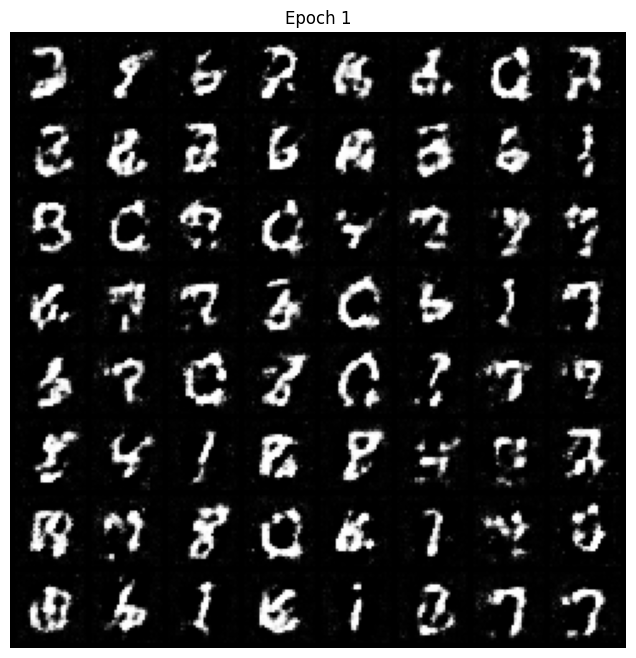

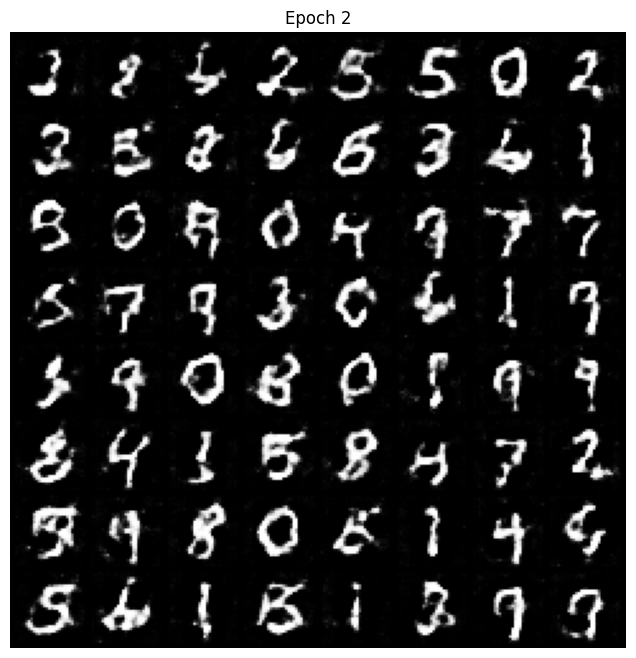

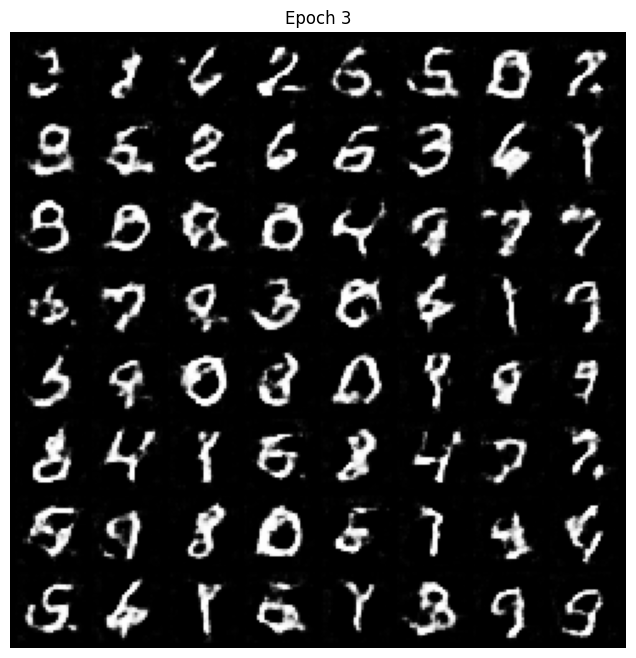

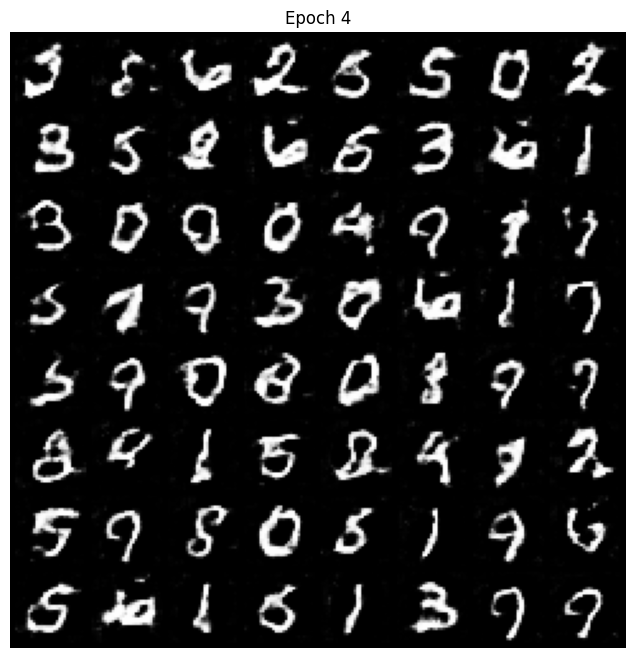

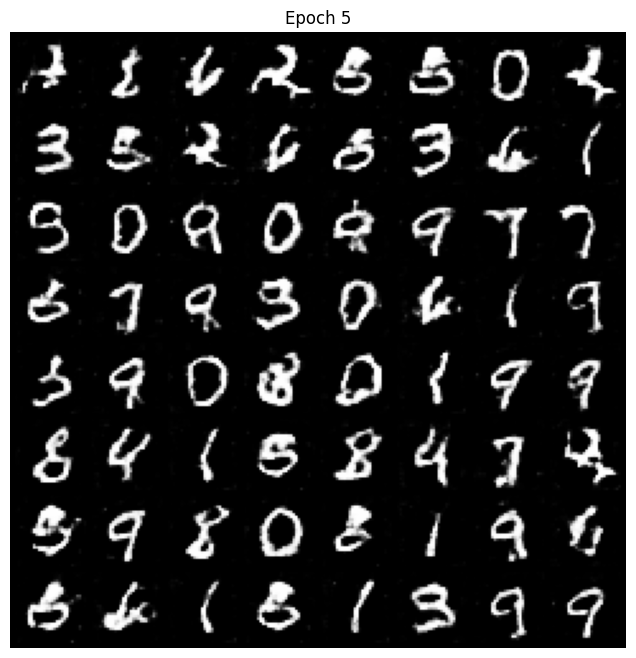

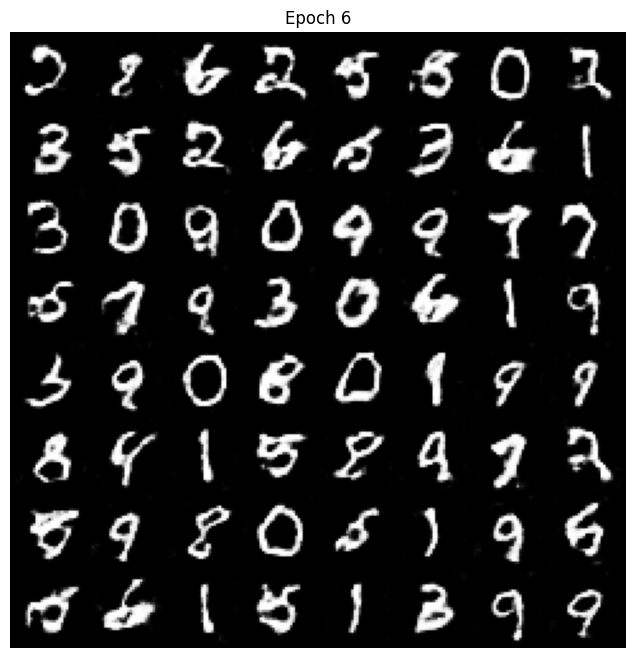

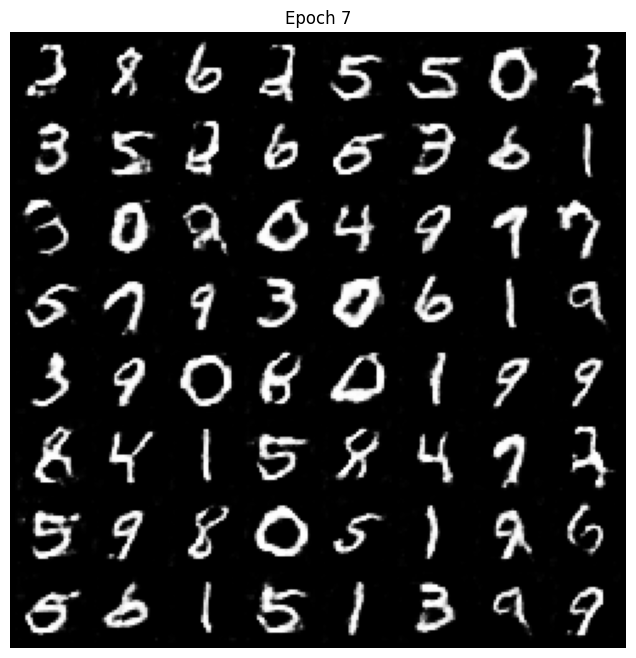

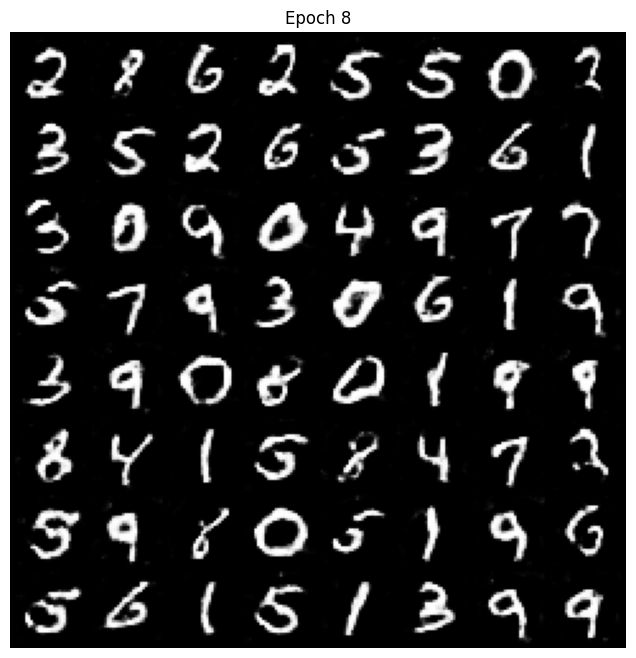

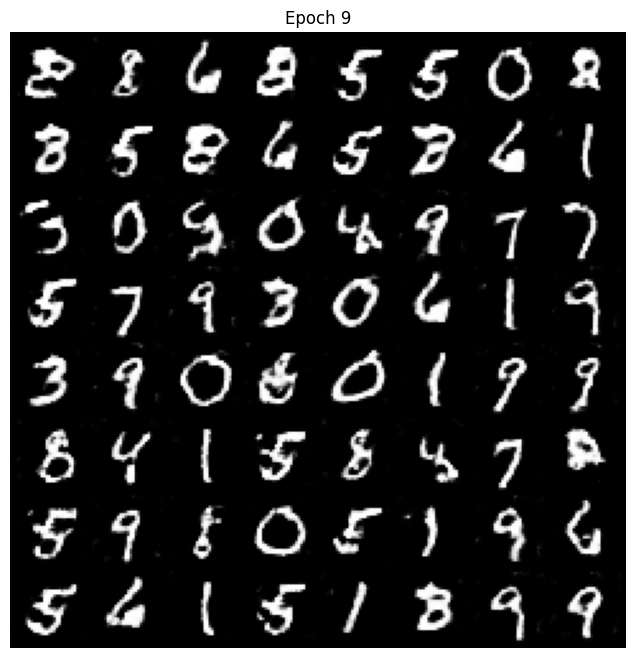

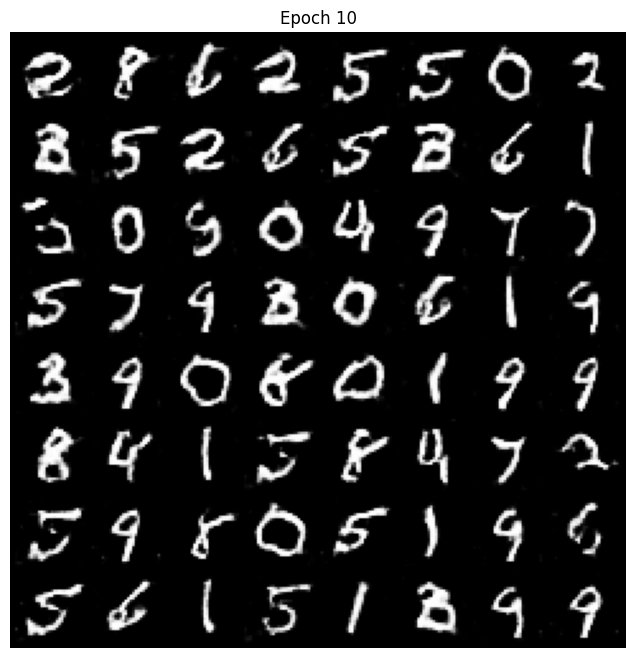

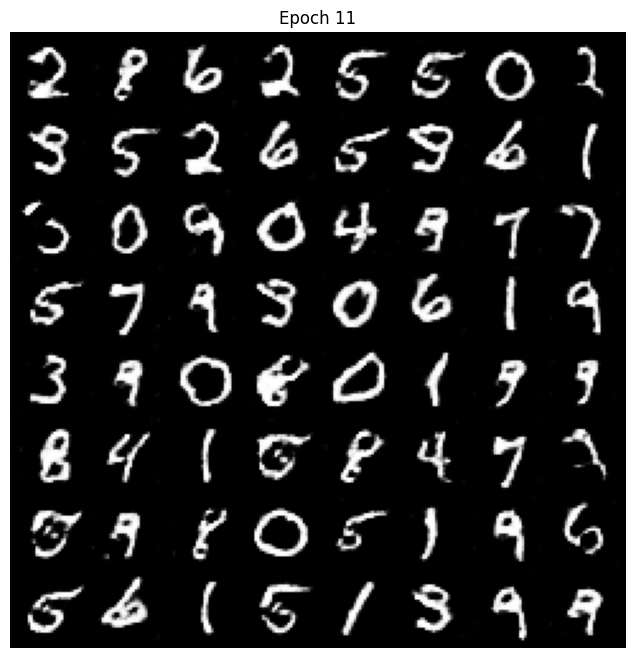

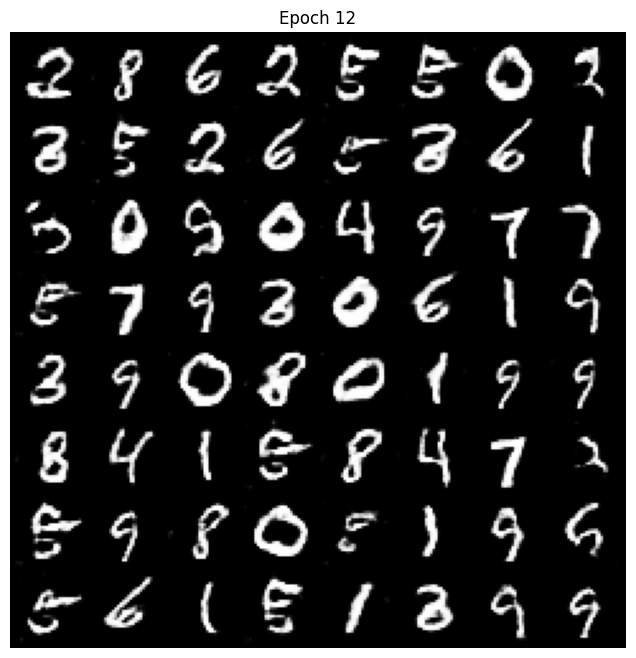

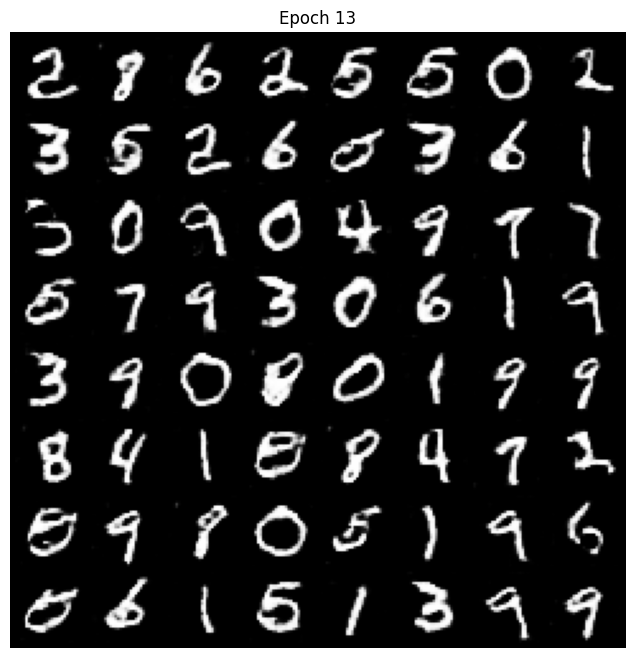

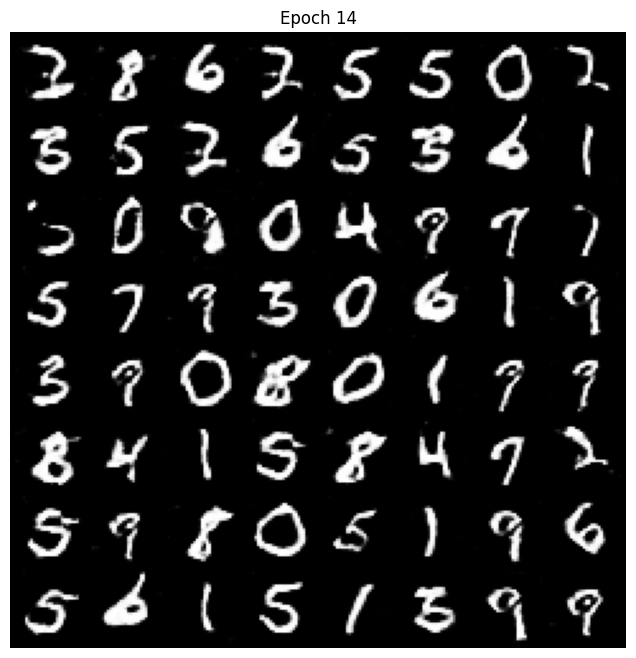

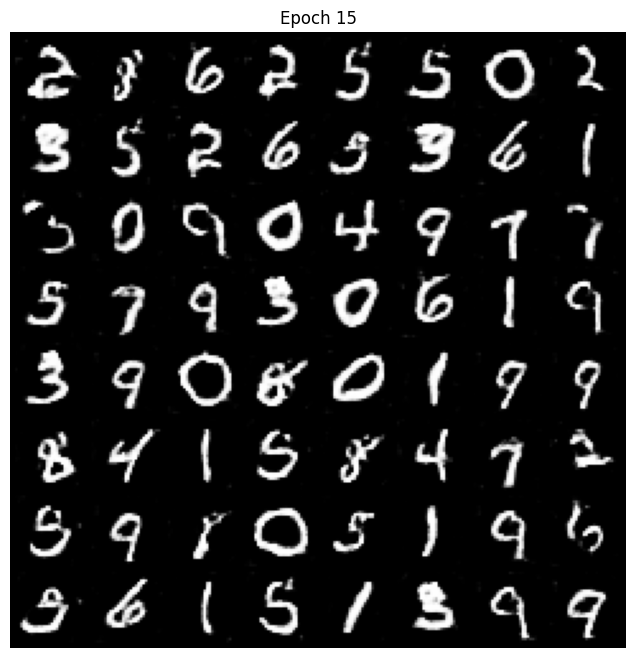

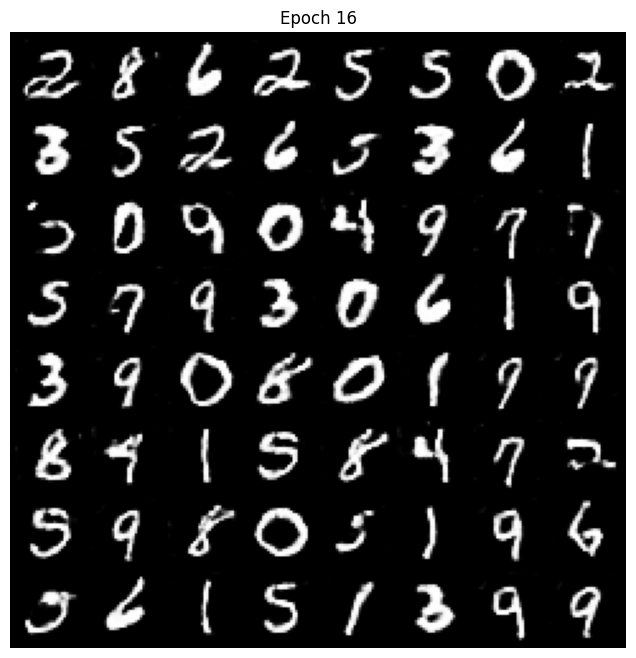

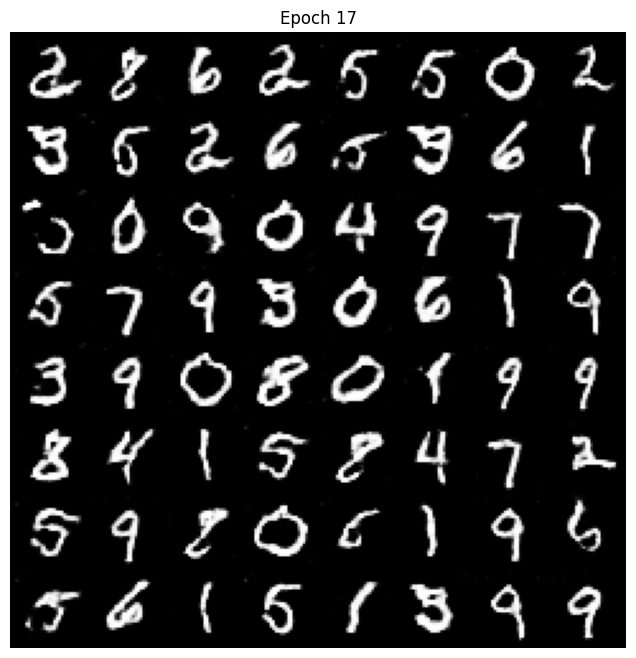

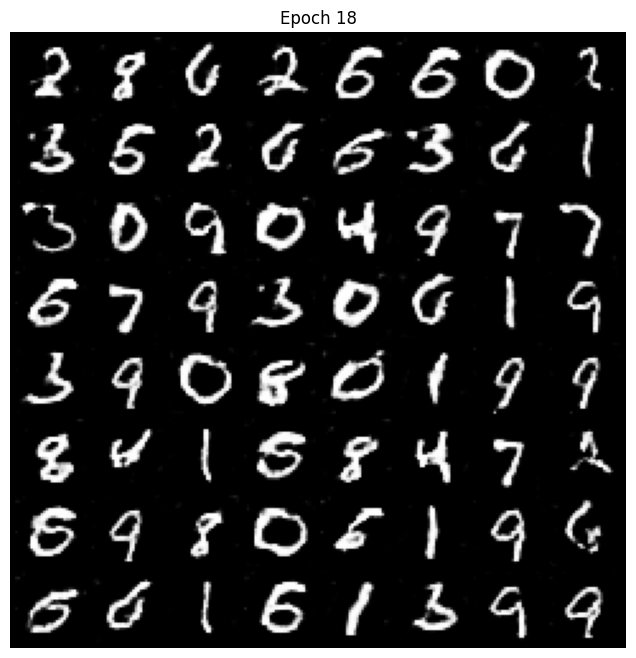

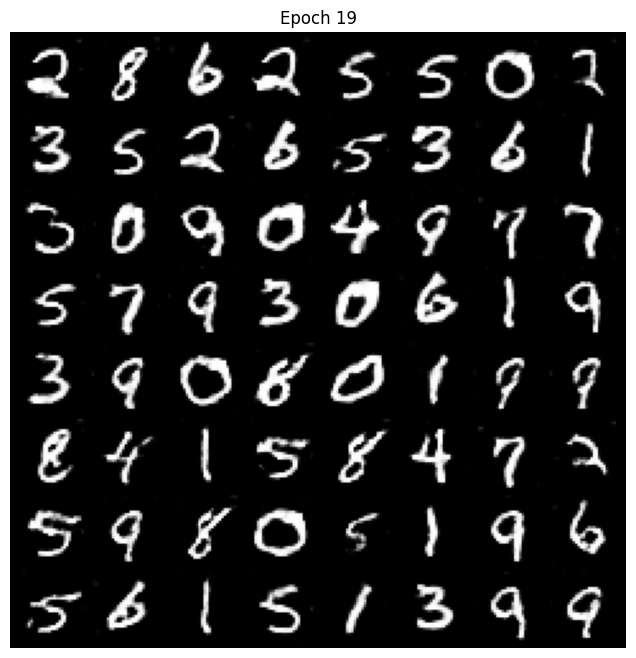

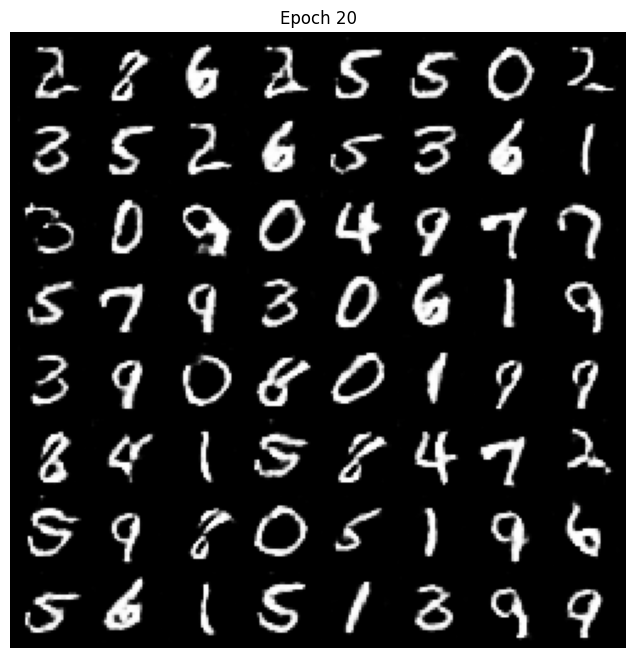

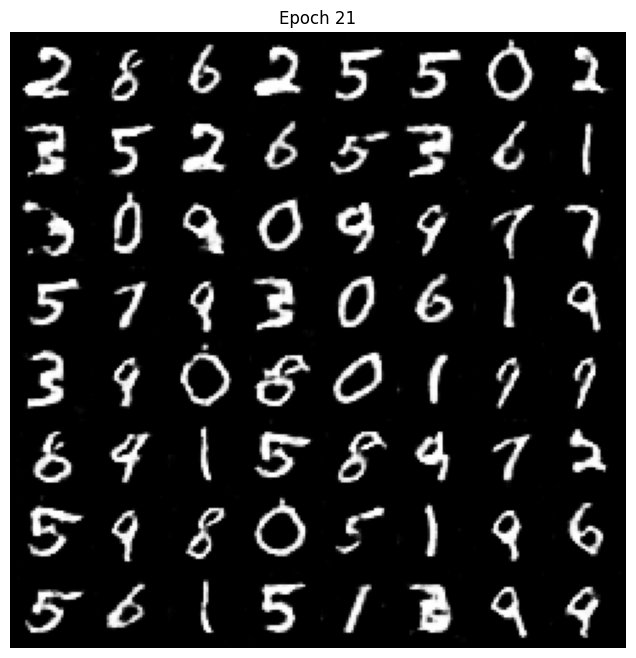

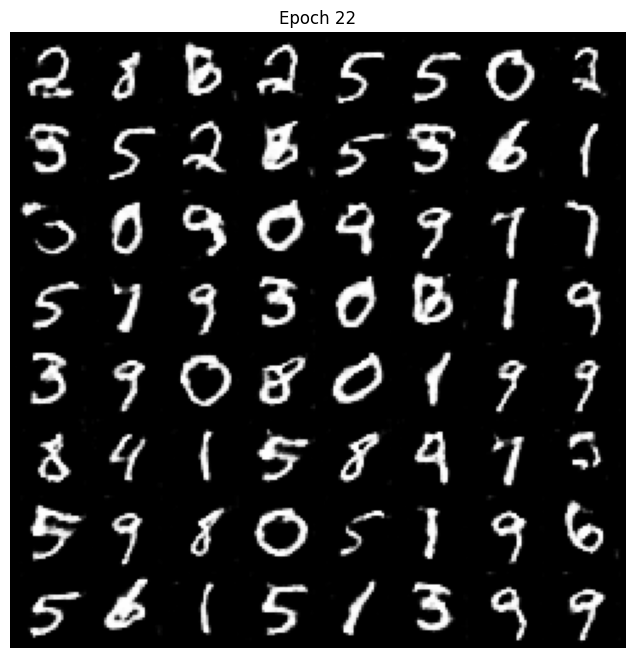

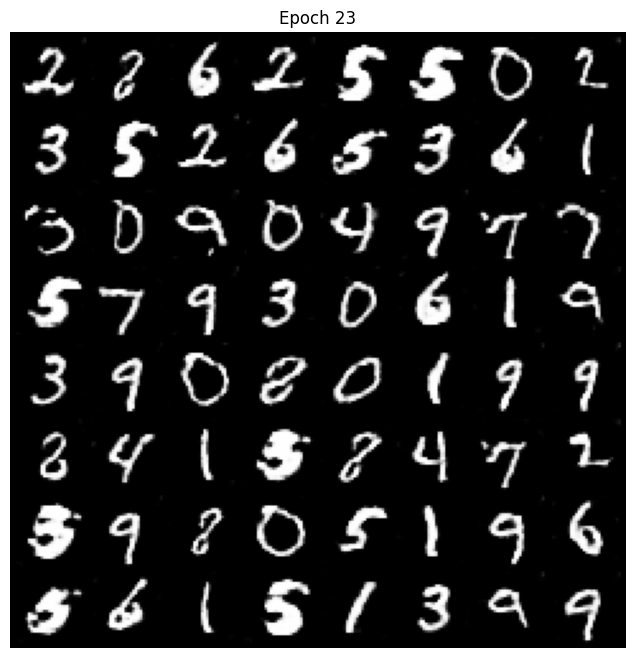

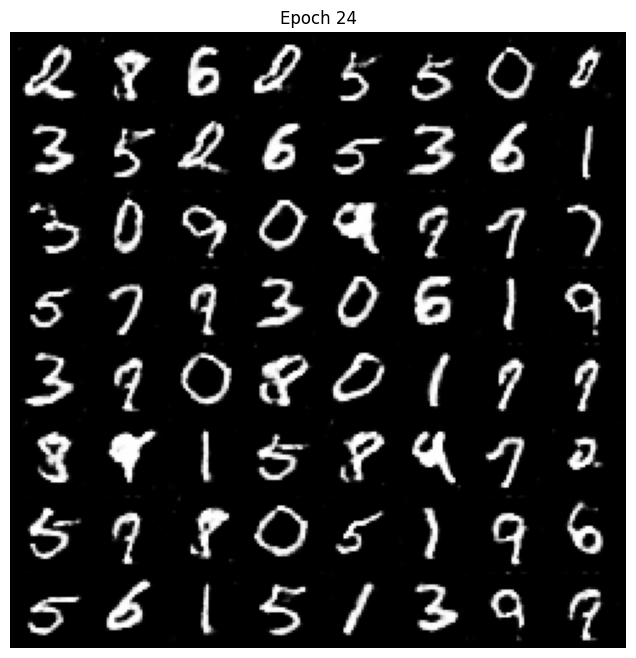

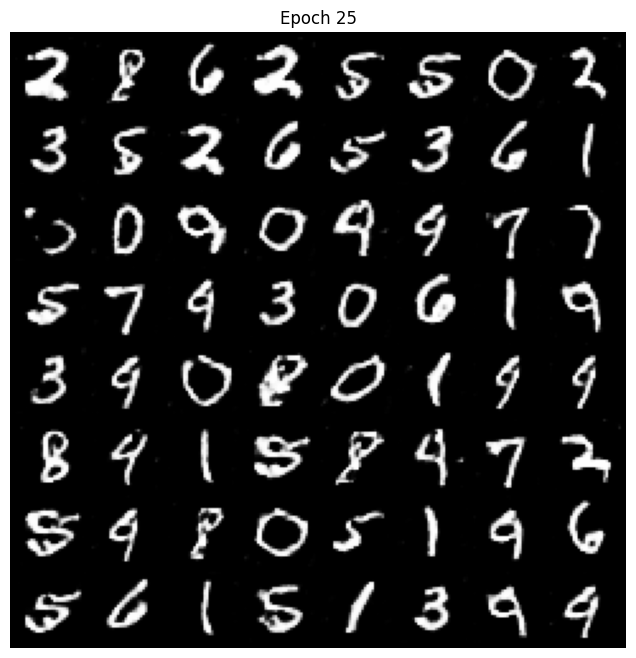

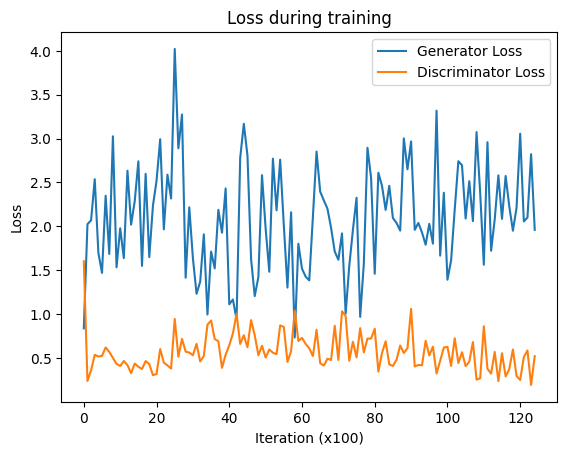

In [14]:
train_model(netG, netD, criterion, optimizerG, optimizerD, dataloader, num_epochs, device)

## Inferencia
Implementar una función que dado un valor entre 0 y 9 muestre 10 imágenes diferentes con representaciones manuscritas del número proporcionado como entrada.

In [16]:
def generate_and_plot_images_for_number(label, generator, nz, device):
    """
    Genera y muestra 10 imágenes distintas para una etiqueta específica (entre 0 y 9) usando el generador entrenado.

    Args:
        label (int): Número entre 0 y 9 que representa la clase de dígito a generar.
        generator (nn.Module): Modelo generador entrenado.
        nz (int): Dimensión del vector de ruido.
        device (torch.device): CPU o GPU.
    """
    assert 0 <= label <= 9, "La etiqueta debe estar entre 0 y 9"

    generator.eval()  # Modo evaluación

    # Generar 10 vectores de ruido aleatorio
    noise = torch.randn(10, nz, device=device)

    # Crear un tensor con 10 etiquetas iguales al número dado
    labels = torch.full((10,), label, dtype=torch.long, device=device)

    # Generar las imágenes
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()

    # Mostrar las imágenes en una cuadrícula
    grid = vutils.make_grid(fake_images, nrow=5, padding=2, normalize=True)

    plt.figure(figsize=(8, 4))
    plt.axis("off")
    plt.title(f"Imágenes generadas para el número: {label}")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

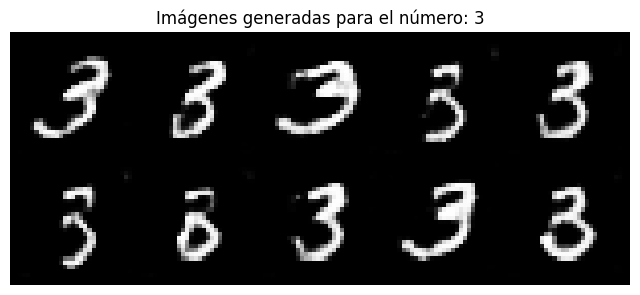

In [17]:
generate_and_plot_images_for_number(3, netG, nz, device)